In [2]:
import numpy as np
from qutip import wigner, fock, Qobj, displace, destroy, tensor, qeye, coherent
from scipy.special import genlaguerre
from math import sqrt, factorial
import qutip
import matplotlib.pyplot as plt
from scipy.linalg import lstsq, eigh, svd  
from scipy.sparse.linalg import LinearOperator, lsqr
import h5py

def make_disps(xmax, N):
    xs = np.linspace(-xmax, xmax, N)
    X, Y = np.meshgrid(xs, xs)
    return (X + 1j*Y).flatten()
# flatten means a matrix can be transformed to a list with the order of row.

def vectorize(rho):
    """
    Turn hermitian matrix rho into a real vector
    vectorize(rho)[:d] = diag(rho)
    vectorize(rho)[d:d + d*(d-1)/2] = Re[upper_triangle(rho)]
    vectorize(rho)[d + d*(d-1)/2:]  = Im[upper_triangle(rho)]
    """
    d = rho.shape[0]  ## the shape of first column - dimension of matrix, e.g. 3x3 matrix d = 3
    n_offd = d*(d-1)//2 
    ret = np.zeros(d**2) #array of zeros with dimensionality d**2
    i = 0
    for m in range(d):
        ret[m] = rho[m, m].real #mth entry in ret is real part of (m,m) diagonal entry of matrix, capped at d
        for n in range(m+1, d):
            ret[d+i] = rho[m, n].real  #set d+ith entry in ret to real part of (m,n) off diagonal entry of matrix
            ret[d+n_offd+i] = rho[m, n].imag
            i += 1
    return ret


def matricize(rvec):
    """
    Invert the vectorize operation such that matricize(vectorize(rho)) == rho
    """
    d = int(np.sqrt(len(rvec)))
    n_offd = d*(d-1)//2
    ret = np.diag(rvec[:d]).astype(np.complex) # 将rvec[:d]转化为一个对角矩阵，并且用a+jb的形式表示
    i = 0
    for m in range(d):
        for n in range(m+1, d):
            real = rvec[d+i]
            imag = rvec[d+n_offd+i]
            val = real + 1j*imag
            ret[m, n] = val
            ret[n, m] = val.conj()
            i += 1
    return ret


def complex_char_mat(disps, d):
    n_disp = len(disps)
    n_offd = (d*(d-1))//2
    dm = np.zeros((n_disp, d*d), dtype=np.complex)
    alpha = disps
    i = 0
    B = abs(alpha)**2
    for n in range(d):
        dm[:, n] = genlaguerre(n, 0)(B)
        for m in range(n+1, d):
            off_d = np.sqrt(factorial(n)/factorial(m)) * genlaguerre(n, m-n)(B)
            dm[:, d+i] = (off_d * (alpha**(m-n) + (-alpha.conjugate())**(m-n)))
            dm[:, d + n_offd + i] = (1j * off_d * (alpha**(m-n) - (-alpha.conjugate())**(m-n)))
            i += 1
    dm = np.einsum('ij,i->ij', dm, np.exp(-B / 2))
    return dm

def reconstruct_char_complex(char, disps, dim):
    M = complex_char_mat(disps, dim)
    rv = lsqr(M, char)[0]
    rho = matricize(rv)
    return rho


# Load and PLot Data

In [3]:
def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

def make_disps(xmax, N):
    xs = np.linspace(-xmax, xmax, N)
    X, Y = np.meshgrid(xs, xs)
    return (1j*X + Y).flatten()

# Create theoretical state and tryout reconstruction

C:\Users\jonat\AppData\Local\Temp\ipykernel_31016\1785901156.py:59: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dm = np.zeros((n_disp, d*d), dtype=np.complex)
C:\Users\jonat\AppData\Local\Temp\ipykernel_31016\1785901156.py:43: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.diag(rvec[:d]).astype(np.complex) # 将r

Text(0.5, 1.0, 'char')

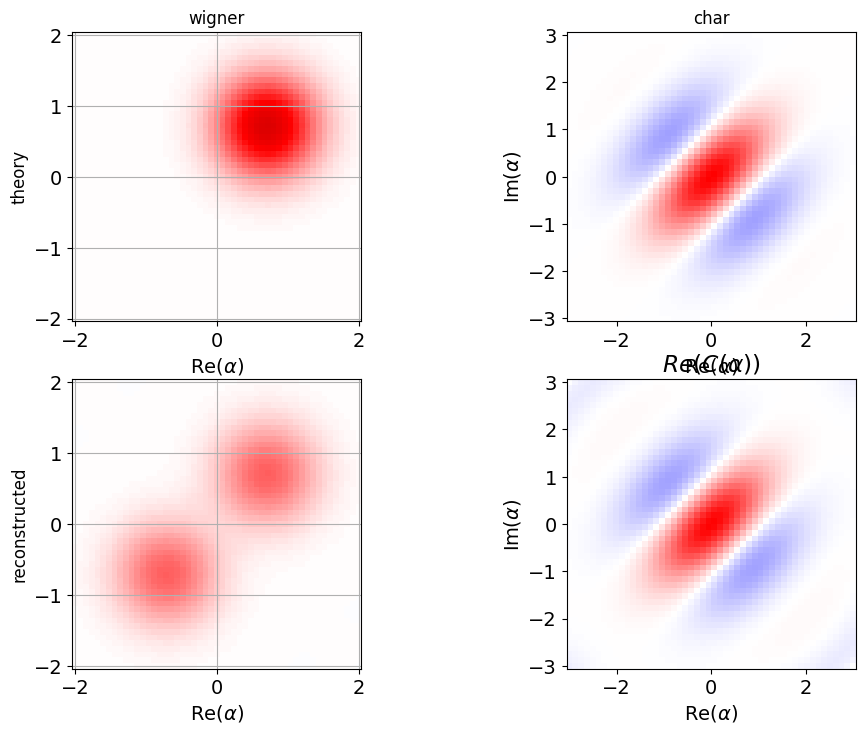

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [3]:
from qutip import*
from tcsim.visualization import*
from tcsim.gates import*
from tcsim.system import*
import matplotlib.pyplot as plt

#psi = tensor(Iq,squeeze(N,calc_squeez_parameter(3)))*vac
psi = tensor(fock(2,0),coherent(N,1*np.exp(1j*np.pi/4))).unit()
xvec = np.linspace(-3,3,31)
char_real, char_im = char_func_grid(psi,xvec)

char_func_flat = (char_real+1j*char_im).flatten()
char_func_flat  = char_real.flatten()*2

rho = Qobj(reconstruct_char_complex(char_func_flat,make_disps(3,31), 10)) 

rho_tensor = tensor(qt.fock(2,0)*qt.fock(2,0).dag(),rho)

fig, ax = plt.subplots(2,2)
plot_wigner(psi, ax = ax[0][0])
plot_char(psi, ax = ax[0][1]) 

plot_wigner(rho_tensor.unit(), ax = ax[1][0])
plot_char(rho_tensor.unit(), ax = ax[1][1]) 



ax[0][0].set_ylabel('theory', fontsize=12)
ax[1][0].set_ylabel('reconstructed', fontsize=12)
ax[0][0].set_title('wigner', fontsize=12)
ax[0][1].set_title('char', fontsize=12)
# plot_wigner(rho)
# plot_char(rho) 

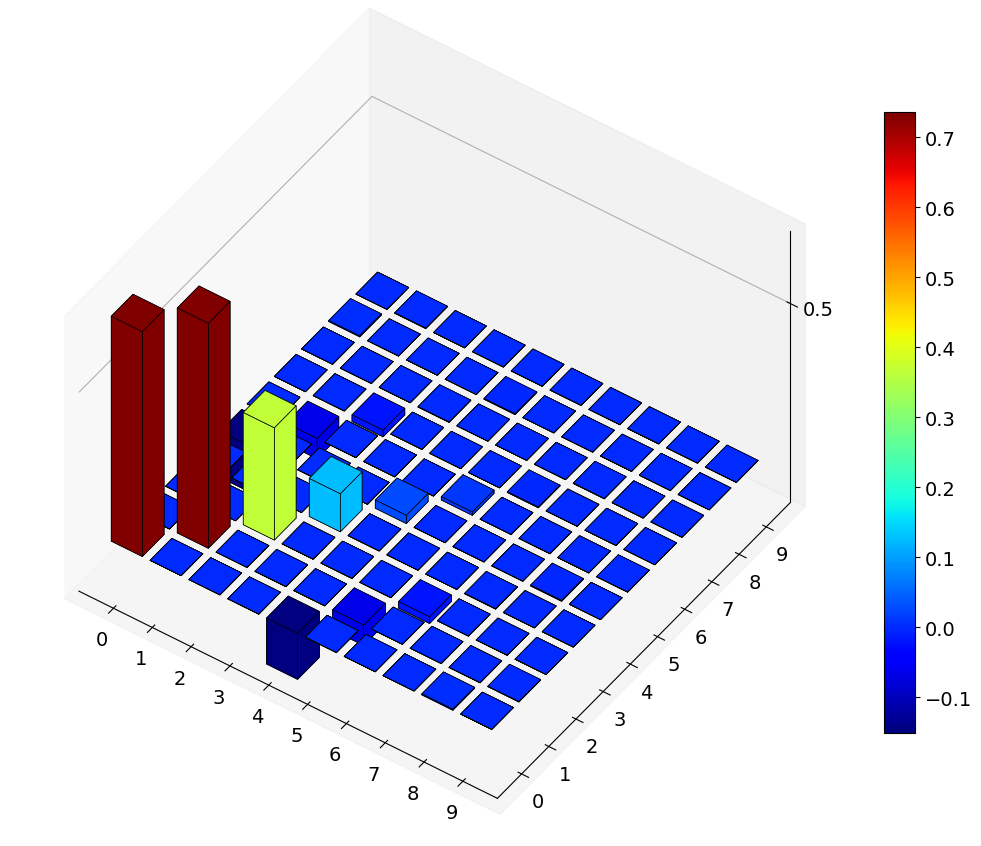

In [10]:
fig, ax = qt.matrix_histogram(rho)

ax.view_init(azim=-55, elev=45)

plt.show()

Text(0.5, 1.0, 'Characteristic_function')

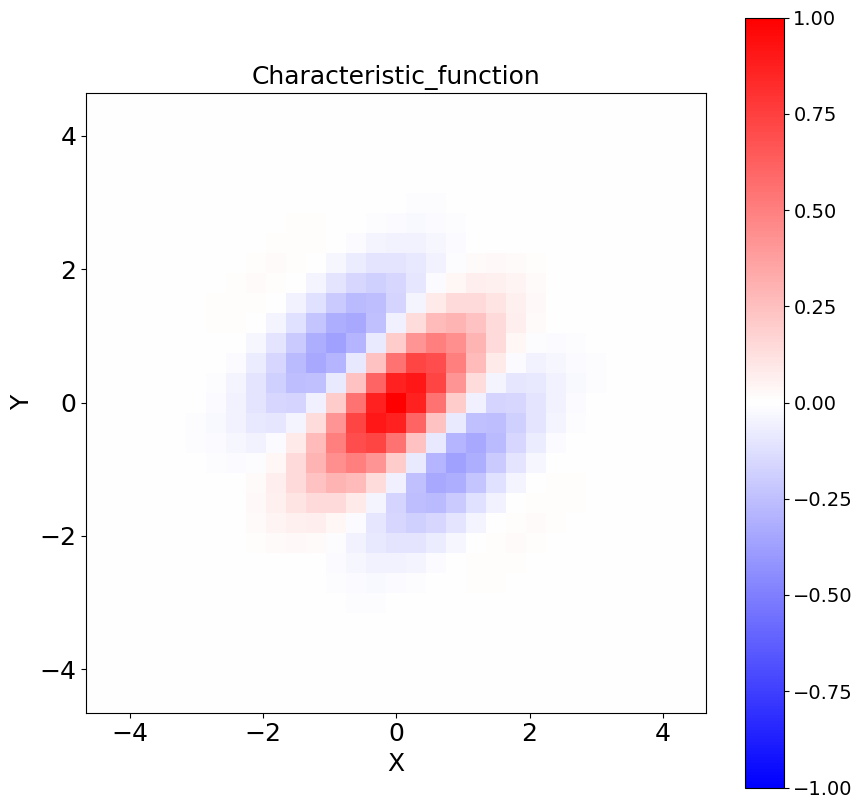

In [9]:
xvec = np.linspace(-4.5,4.5,31)
char_real, char_im = char_func_grid(psi,xvec)

# plot theoretical char func grid
fig, ax = plt.subplots(figsize = (10,10) )
ax.set_aspect('equal')
plt.pcolormesh(xvec, xvec, char_real, cmap = 'bwr', vmin = -1, vmax = 1) # [4:31]
plt.colorbar()
plt.xlabel("X", fontsize = 18)
plt.ylabel('Y', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Characteristic_function', fontsize=18)

# Try real Data

ValueError: too many values to unpack (expected 2)

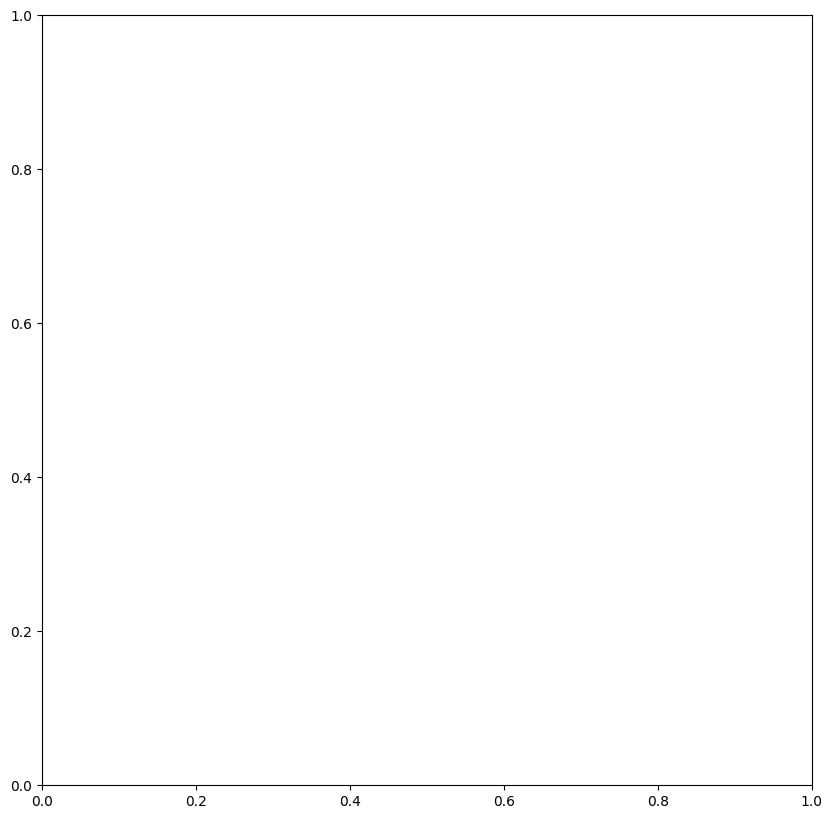

In [6]:
import h5py

# opening the file and loading the data
filepath = (
    r"C:\Users\jonat\Desktop\Coding\tcsim\Data Analysis\Data\091258_panther_cat_fringe_decay_real.h5"
)
f = h5py.File(filepath, "r")
data_iavg = f['data']['I_AVG']
data_iavg.shape
z = np.array(data_iavg) # minus sign to make epxeriment and simulation have the same polarity
z_flat = z.flatten()


# Data Plotting
x_data = np.array(f['data']['x']) # -1.8 to including 1.8
y_data = np.array(f['data']['y'])

fig, ax = plt.subplots(figsize = (10,10) )
ax.set_aspect('equal')
plt.pcolormesh(x_data, y_data, z, cmap = 'bwr') # [4:31]
plt.colorbar()
plt.xlabel("X", fontsize = 18)
plt.ylabel('Y', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Characteristic_function', fontsize=18)

In [127]:
def scale(col, min, max):
    range = col.max() - col.min()
    a = (col - col.min()) / range
    return a * (max - min) + min

zscale =scale(z,-0.6, 1)


In [132]:
z = (z-np.mean(z[0]))/np.max(z)

In [133]:
X, Y = np.meshgrid(x_data, y_data)
disps = (1j*x_data + y_data).flatten()
rho = Qobj(reconstruct_char_complex(z.flatten(), disps*4 , 12))


C:\Users\jonat\AppData\Local\Temp\ipykernel_18264\1785901156.py:59: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dm = np.zeros((n_disp, d*d), dtype=np.complex)
C:\Users\jonat\AppData\Local\Temp\ipykernel_18264\1785901156.py:43: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.diag(rvec[:d]).astype(np.complex) # 将r

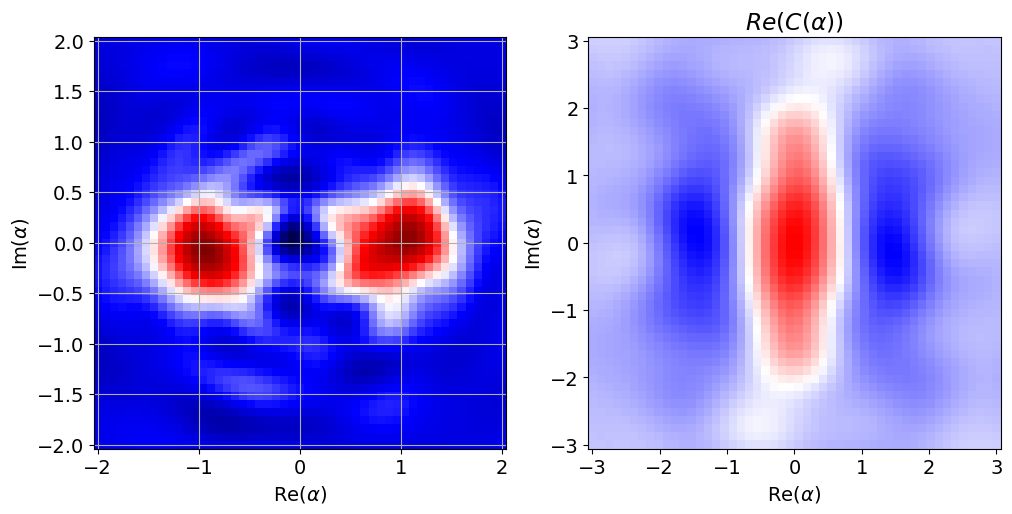

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [134]:

rho_tensor = qt.tensor(qt.fock(2,0)*qt.fock(2,0).dag(),rho)

fig, ax = plt.subplots(1,2)

plot_wigner(rho_tensor.unit(), ax = ax[0], vmin = None, vmax = None)
plot_char(rho_tensor.unit(), ax = ax[1], vmin = None, vmax = None)

In [7]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

if 1:
    filepath = r"C:\Users\jonat\Desktop\Coding\tcsim\Data Analysis\Data\cat_decay_data\091258_panther_cat_fringe_decay_real.h5"
    file = h5py.File(filepath, "r")
    data = file["data"]
    data_i = data["I"][:]
    # state = data["state"][:]
    x_data = data["x"][:, 0][:, 0]
    n_points = len(x_data)  # sweep points
    thresh = 1.736310313628283e-05
    ss_data = np.where(data_i < thresh, 1, 0)
    m1 = ss_data[:, 0::2]  # .mean(axis=0) # first measurement, we use as mask
    m2 = ss_data[:, 1::2]  # .mean(axis=0) # second measurement
    mask = np.zeros_like(m1)
    mx_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(n_points, n_points) * 2 - 1
    mx_e = (
        ma.masked_array(m2, mask=np.logical_not(m1))
        .mean(axis=0)
        .reshape(n_points, n_points)
    ) * 2 - 1
    mx_ge = m2.mean(axis=0).reshape(n_points, n_points) * 2 - 1

    # # test = m1.mean(axis=0).reshape(31, 31)
#     fig, ax = plt.subplots()
    proj_ge = [mx_g, mx_e, mx_ge]  # m2.mean(axis = 0).reshape(n_points, n_points)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    f1 = ax1.pcolormesh(x_data, x_data, mx_g, cmap="seismic", vmax=1, vmin=-1)
    f2 = ax2.pcolormesh(x_data, x_data, mx_e, cmap="seismic", vmax=1, vmin=-1)
    ax1.set_aspect("equal")
    ax1.set_xlabel(r"real($\beta$)")
    ax1.set_ylabel(r"imag($\beta$)")
    ax2.set_aspect("equal")
    ax2.set_xlabel(r"real($\beta$)")


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'C:\Users\jonat\Desktop\Coding\tcsim\Data Analysis\Data\cat_decay_data\091258_panther_cat_fringe_decay_real.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)